In [46]:
from Dataset.generate_datasets import make_gravitational_waves
from pathlib import Path
from gtda.time_series import SlidingWindow, TakensEmbedding
import numpy as np

In [ ]:
Rmin = 0.5
Rmax = 0.97
n_signals = 100
DATA = Path("./Dataset")

noisy_signals, gw_signals, labels = make_gravitational_waves(
    path_to_data=DATA, n_signals=n_signals, r_min=Rmin, r_max=Rmax, n_snr_values=1
)
noisy_signals = np.array(noisy_signals)
gw_signals = np.array(gw_signals)
labels = np.array(labels)
print(f"Number of labels: {len(labels)}")
print(f"Number of noisy signals: {len(noisy_signals)}")
print(f"Number of GW signals: {len(gw_signals)}")
print(f"Number of timesteps per series: {len(noisy_signals[0])}")
# Print the shape of the noisy_signals and gw_signals
print(f"Shape of noisy_signals: {len(noisy_signals[0])}")
print(f"Shape of gw_signals: {len(gw_signals[0])}")

Number of labels: 200
Number of noisy signals: 200
Number of GW signals: 200
Number of timesteps per series: 8692
Shape of noisy_signals: 8692
Shape of gw_signals: 8192


In [68]:
from gtda.diagrams import PersistenceEntropy, Scaler
from gtda.homology import VietorisRipsPersistence
from gtda.metaestimators import CollectionTransformer
from gtda.pipeline import Pipeline
from gtda.time_series import TakensEmbedding
from sklearn.decomposition import PCA

def getPipe():
    embedding_dimension = 200
    embedding_time_delay = 10
    stride = 10

    embedder = TakensEmbedding(time_delay=embedding_time_delay,
                            dimension=embedding_dimension,
                            stride=stride)

    batch_pca = CollectionTransformer(PCA(n_components=3), n_jobs=-1)

    persistence = VietorisRipsPersistence(homology_dimensions=[1], n_jobs=-1)

    scaling = Scaler()

    entropy = PersistenceEntropy(normalize=True, nan_fill_value=-10)


    steps = [("embedder", embedder),
            ("pca", batch_pca),
            ("persistence", persistence),
            ("scaling", scaling)]

    return Pipeline(steps)

In [80]:
def getPipe2(pipe, signal, fixed = 200):
    betti = pipe.fit_transform(signal)
    print (betti.shape)
    # Eliminamos el tercer eje porque solo es el tipo de homología y solo queremos la primera dimensión, asi que es redundante
    betti = betti[:, :, 0:2].transpose(0, 2, 1)
    # Ordenamos los datos para que sean consistentes
    def sort_persistence(x):
        def time_life_diagram(x):
            return x[1] - x[0]
        return np.array([sorted(betti[i], key=time_life_diagram) for i in range(len(betti))])
    ordered = sort_persistence(betti)
    ordered = ordered[:, :, 0:fixed]
    return ordered

In [81]:
pipe = getPipe()
betti = getPipe2(pipe, noisy_signals)

/home/felipe/.local/lib/python3.8/site-packages/sklearn/utils/metaestimators.py:121: FutureWarning:

if_delegate_has_method was deprecated in version 1.1 and will be removed in version 1.3. Use available_if instead.



(200, 368, 3)


In [82]:
betti.shape

(200, 2, 368)

In [77]:
# Print the shape of the features
print(f"Shape of features: {betti.shape}")
print (betti[0])

Shape of features: (200, 2, 365)
[[1.72950133 1.7239789  1.72093423 1.57229496 1.56405817 1.53923752
  1.36874513 1.3451101  1.34088554 1.34000125 1.33364071 1.32658682
  1.29010437 1.27824214 1.27803066 1.2662787  1.26049465 1.22839644
  1.22074542 1.2180322  1.21742246 1.21625549 1.20930501 1.17472069
  1.16230083 1.15954832 1.15403068 1.14517549 1.14481517 1.10999686
  1.09873322 1.09305027 1.07826511 1.07485053 1.06849145 1.06467172
  1.06037045 1.0591421  1.04962713 1.04416755 1.01228238 1.01129647
  1.00966235 1.00872011 0.99597723 0.99231281 0.98733019 0.98110285
  0.97901544 0.97843029 0.97804047 0.97175778 0.96963148 0.96371788
  0.95748741 0.9482892  0.94406267 0.94262669 0.93985052 0.9365313
  0.93386437 0.93222503 0.93074361 0.92292582 0.92272539 0.91917218
  0.91894642 0.91601588 0.91428347 0.91253605 0.91027165 0.90840072
  0.89913455 0.89613532 0.89516963 0.89001086 0.88521658 0.87848362
  0.8643611  0.86055238 0.85708141 0.85631709 0.85352048 0.84902248
  0.84417916 0.8

In [51]:
# Ordenar en base a el tiempo de vida de los diagramas de persistencia
fixed = 200
# Ordenamos primero en base a la dimensión 1
def sort_persistence(x):
    def time_life_diagram(x):
        return x[1] - x[0]
    return np.array([sorted(features[i], key=time_life_diagram) for i in range(len(features))])
ordered = sort_persistence(features)
# Save the life
lifes = np.array([ordered[i][:,1] - ordered[i][:,0] for i in range(len(ordered))])


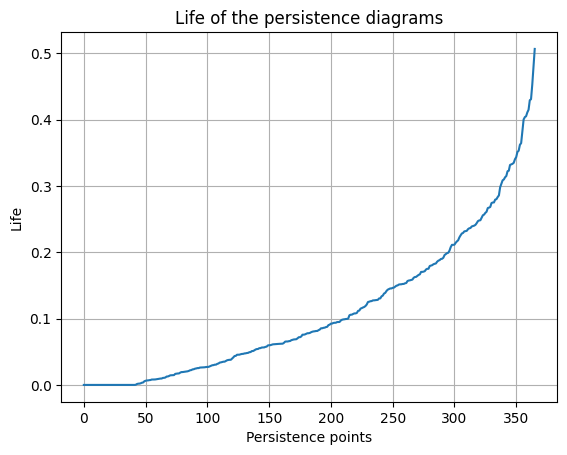

In [52]:
# Usando el plot diagramas de gtda
import matplotlib.pyplot as plt

# Plot the life of the diagrams
fig, ax = plt.subplots()
ax.plot(lifes[0])
ax.set(xlabel='Persistence points', ylabel='Life',
       title='Life of the persistence diagrams')
ax.grid()
plt.show()

In [53]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    features, labels, test_size=0.1, random_state=42
)
print (X_train.shape)
print (X_valid.shape)
print (y_train.shape)
print (y_valid.shape)

(180, 366, 3)
(20, 366, 3)
(180,)
(20,)
